<a href="https://colab.research.google.com/github/silentfortin/ai-portfolio/blob/main/07-cv-flower-recognition/cv_flower_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import os
import requests
import tarfile
import io
import json

import numpy as np
import random
from collections import Counter

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import seaborn as sns

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

from PIL import Image, UnidentifiedImageError


In [3]:
# Set random seed for reproducibility of results
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
BATCH_SIZE = 128
EPOCHS = 40

In [5]:
# Choose device: GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using this device: {device}')

Using this device: cpu


In [6]:
# Download and unzip the dataset from the given URL
url = 'https://proai-datasets.s3.eu-west-3.amazonaws.com/progetto-finale-flowes.tar.gz'

response = requests.get(url)
response.raise_for_status()

with tarfile.open(fileobj=io.BytesIO(response.content), mode='r:gz') as tar:
    tar.extractall(path="/content/")

/tmp/ipython-input-517670830.py:8: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path="/content/")


In [7]:
# Check if image is valid
def is_valid_image(file_path):
  try:
    with Image.open(file_path) as img:
      img.verify()
    return True
  except (IOError, UnidentifiedImageError):
      return False

In [8]:
def filter_invalid_images(images_dir):
  valid_file = []
  for class_name in os.listdir(images_dir):
    class_folder = os.path.join(images_dir, class_name)
    if os.path.isdir(class_folder):
      for file_name in os.listdir(class_folder):
        if not file_name.startswith('._'):
          file_path = os.path.join(class_folder, file_name)
          if is_valid_image(file_path):
            valid_file.append(file_path)
  return valid_file

In [31]:
def plot_class(ax, img_dataset, title):
    idx_to_class = {0: 'daisy', 1: 'dandelion'}
    all_labels = []
    for index in range(len(img_dataset)):
        _, label = img_dataset[index]
        all_labels.append(label)

    labels_count = Counter(all_labels)
    labels = [0, 1]
    counts = [labels_count.get(idx, 0) for idx in labels]
    class_names = [idx_to_class[idx] for idx in labels]

    bars = ax.bar(class_names, counts, color='orange')
    ax.set_xlabel('Class', fontsize=12)
    ax.set_ylabel('# of Images', fontsize=12)
    ax.set_title(title, fontsize=14)
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval + 2, int(yval),
                ha='center', va='bottom', fontsize=11)

In [13]:
class FlowerDataset(Dataset):
    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        self.class_map = {'daisy':0, 'dandelion':1}
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        img_path = self.files[idx]
        image = Image.open(img_path).convert("RGB")
        # taking name of the folder which contains the img e.g. dog
        label_name = os.path.basename(os.path.dirname(img_path))
        label = self.class_map[label_name]
        if self.transform:
            image = self.transform(image)
        return image, label

In [15]:
# Create list of valid files for each split
train_valid_files = filter_invalid_images('/content/progetto-finale-flowes/train')
val_valid_files   = filter_invalid_images('/content/progetto-finale-flowes/valid')
test_valid_files  = filter_invalid_images('/content/progetto-finale-flowes/test')

# Define transforms (can be different per split)
from torchvision import transforms
train_transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
val_transform   = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
test_transform  = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

# Create a FlowerDataset instance for each split
train_dataset = FlowerDataset(train_valid_files, transform=train_transform)
val_dataset   = FlowerDataset(val_valid_files,   transform=val_transform)
test_dataset  = FlowerDataset(test_valid_files,  transform=test_transform)

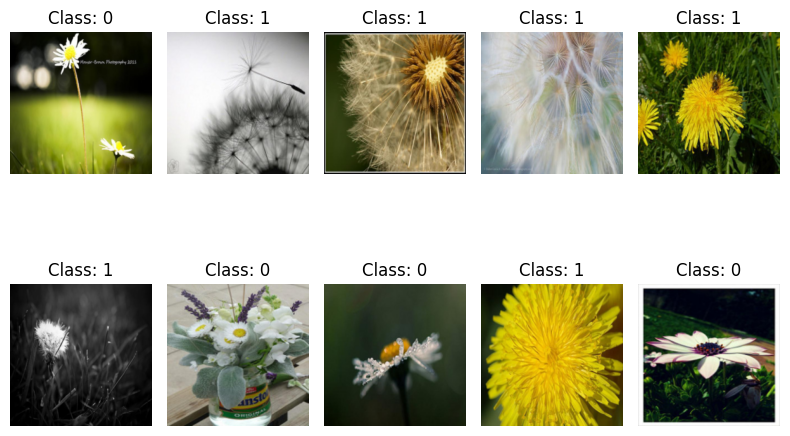

In [21]:
indices = random.sample(range(len(train_dataset)), 10)

plt.figure(figsize = (8,6))
for i, index in enumerate(indices):
  image, label = train_dataset[index]
  # if img is tensor
  if isinstance(image, torch.Tensor):
    img_np = image.permute(1,2,0).numpy()
  else:
    img_np = np.array(image)
  plt.subplot(2,5,i+1)
  plt.imshow(img_np)
  plt.title(f"Class: {label}")
  plt.axis('off')
plt.tight_layout()
plt.show()

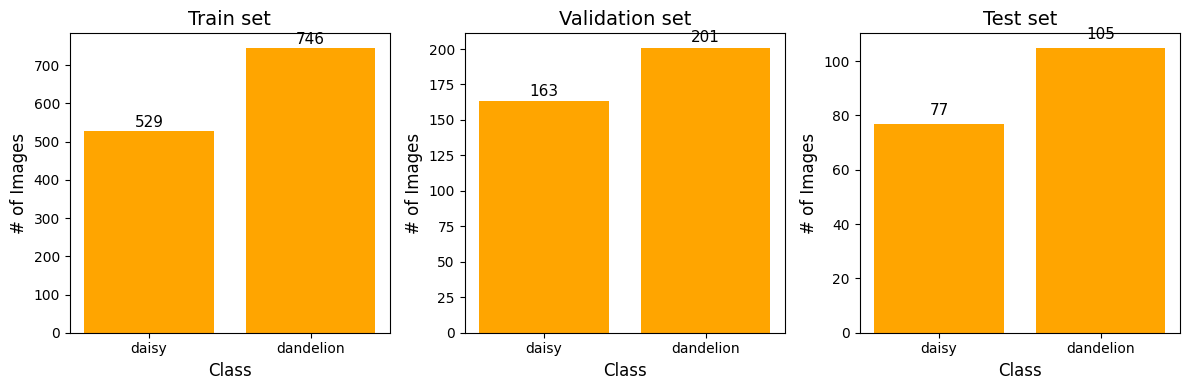

In [45]:
# Create a row of 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plot_class(axes[0], train_dataset, "Train set")
plot_class(axes[1], val_dataset, "Validation set")
plot_class(axes[2], test_dataset, "Test set")
plt.tight_layout()
plt.show()

In [37]:
def check_unique_shape(dataset):
    # Set collects all unique (width, height) pairs
    unique_shapes = set()
    for img_path in dataset.files:
        with Image.open(img_path) as img:
            unique_shapes.add(img.size)  # Note: img.size = (width, height)
    if len(unique_shapes) == 1:
        w, h = next(iter(unique_shapes))
        print(f"All images have the same size: width={w}, height={h}")
    else:
        print(f"Multiple different image sizes found: {unique_shapes}")

In [50]:
print('Train set:')
check_unique_shape(train_dataset)
print('\nValidation set:')
check_unique_shape(val_dataset)
print('\nTest set:')
check_unique_shape(test_dataset)

Train set:
All images have the same size: width=512, height=512

Validation set:
All images have the same size: width=512, height=512

Test set:
All images have the same size: width=512, height=512
